<IPython.core.display.Javascript object>


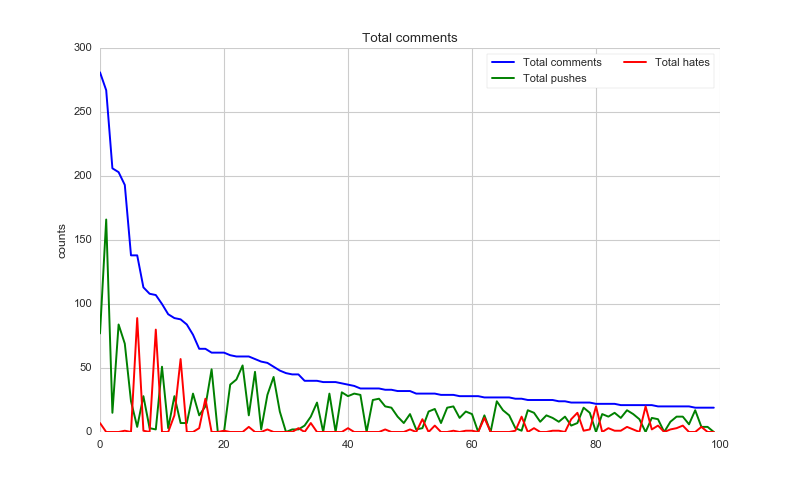

In [1]:
%matplotlib notebook
import json

from collections import defaultdict

from jieba import jieba
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

from sklearn.feature_extraction import DictVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.svm import LinearSVC

sns.set(style='whitegrid')

# load ptt posts

path = 'pttstock_preview.json'

with open(path) as f:
    posts = json.load(f)
    
# get pushes

total_comments = defaultdict(int)
total_pushes = defaultdict(int)
total_hates = defaultdict(int)

for post in posts:
    for comment in post['comments']:
        user = comment['user']
        total_comments[user] += 1

        if comment['score'] > 0:
            total_pushes[user] += 1

        elif comment['score'] < 0:
            total_hates[user] += 1

def show_distributions(counts, pushes, hates):
    sorted_cnts = [t[0] for t in sorted(counts.items(), key=lambda x: -x[1])][:100]
    y = [counts[u] for u in sorted_cnts]
    y_pushes = [pushes[u] for u in sorted_cnts]
    y_hates = [hates[u] for u in sorted_cnts]
    x = range(len(y))

    f, ax = plt.subplots(figsize=(10, 6))

    sns.set_color_codes('pastel')
    sns.plt.plot(x, y, label='Total {}'.format('comments'), color='blue')
    sns.plt.plot(x, y_pushes, label='Total {}'.format('pushes'), color='green')
    sns.plt.plot(x, y_hates, label='Total {}'.format('hates'), color='red')

    ax.legend(ncol=2, loc='upper right', frameon=True)
    ax.set(ylabel='counts',
           xlabel='',
           title='Total comments')
    sns.despine(left=True, bottom=True)

    plt.show(f)

# display pushes
show_distributions(total_comments, total_pushes, total_hates)

In [2]:
# grap post
words = []
scores = []

for post in posts:
    d = defaultdict(int)
    content = post['content']
    if post['score'] != 0:
        for l in content.split('\n'):
            if l:
                for w in jieba.cut(l):
                    d[w] += 1
        if len(d) > 0:
            words.append(d)
            scores.append(1 if post['score'] > 0 else 0)

Building prefix dict from the default dictionary ...
Loading model from cache /var/folders/nc/fl85yyxn3mxcdt_b5h8d1gtr0000gn/T/jieba.cache
Loading model cost 1.171 seconds.
Prefix dict has been built succesfully.


In [3]:
# grap comments
c_words = []
c_scores = []

for post in posts:
    for comment in post['comments']:
        l = comment['content'].strip()
        if l and comment['score'] != 0:
            d = defaultdict(int)
            for w in jieba.cut(l):
                d[w] += 1
            if len(d) > 0:
                c_scores.append(1 if comment['score'] > 0 else 0)
                c_words.append(d)


In [4]:
# convert to vectors
dvec = DictVectorizer()
tfidf = TfidfTransformer()
X = tfidf.fit_transform(dvec.fit_transform(words))

c_dvec = DictVectorizer()
c_tfidf = TfidfTransformer()
c_X = c_tfidf.fit_transform(c_dvec.fit_transform(c_words))

svc = LinearSVC()
svc.fit(X, scores)

c_svc = LinearSVC()
c_svc.fit(c_X, c_scores)

LinearSVC(C=1.0, class_weight=None, dual=True, fit_intercept=True,
     intercept_scaling=1, loss='squared_hinge', max_iter=1000,
     multi_class='ovr', penalty='l2', random_state=None, tol=0.0001,
     verbose=0)

In [5]:
def display_top_features(weights, names, top_n, select=abs):
    top_features = sorted(zip(weights, names), key=lambda x: select(x[0]), reverse=True)[:top_n]
    top_weights = [x[0] for x in top_features]
    top_names = [x[1] for x in top_features]

    fig, ax = plt.subplots(figsize=(10,8))
    ind = np.arange(top_n)
    bars = ax.bar(ind, top_weights, color='blue', edgecolor='black')
    for bar, w in zip(bars, top_weights):
        if w < 0:
            bar.set_facecolor('red')

    width = 0.30
    ax.set_xticks(ind + width)
    ax.set_xticklabels(top_names, rotation=45, fontsize=12, fontdict={'fontname': 'Heiti TC', 'fontsize':12})

    #plt.show(fig)
    return top_features

<IPython.core.display.Javascript object>


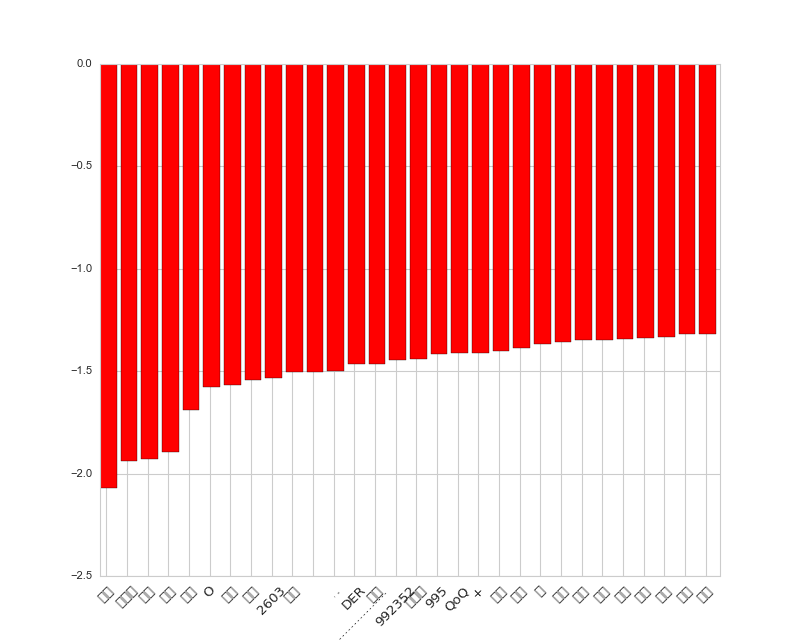

[(-2.0718358666935619, '少年'),
 (-1.9377996435057641, '只會漲'),
 (-1.9273377182038141, '一人'),
 (-1.8958410104405703, '澤澤'),
 (-1.6917823681211028, '味全'),
 (-1.5751544961431188, 'O'),
 (-1.565975437581016, '你媽'),
 (-1.543502152635104, '通通'),
 (-1.5348891509169464, '2603'),
 (-1.5057478228060506, '媽的'),
 (-1.5017704627759718, '................................................'),
 (-1.500549838955437, '八'),
 (-1.4666769529268189, 'DER'),
 (-1.4649522671425077, '股版'),
 (-1.4470522955337475, '992352'),
 (-1.4423011547195599, '落水狗'),
 (-1.4160477314708406, '995'),
 (-1.4133046153497075, 'QoQ'),
 (-1.4125706396614206, '+'),
 (-1.4022946814806332, '累進'),
 (-1.38728108738622, '高興'),
 (-1.3663091614594274, '行'),
 (-1.3550236771063757, '低調'),
 (-1.3488913844029293, '炸裂'),
 (-1.345598839890868, '雞年'),
 (-1.3424716906221947, '專心'),
 (-1.3371598356459624, '老二'),
 (-1.3344013387474405, '喊盤'),
 (-1.3189680306747704, '古神'),
 (-1.3172276113378409, '八卦')]

In [6]:
# top features for comments
display_top_features(c_svc.coef_[0], c_dvec.get_feature_names(), 30)